# GRANDMA/Kilonova-catcher --- KN-LC

The purpose of this notebook is to inspect the ZTF alerts that were selected by the Fink KN-LC filter as potential Kilonova candidates in the period 2021/04/01 to 2021/08/31, and forwarded to the GRANDMA/Kilonova-catcher project for follow-up observations.

This filter uses the following cuts:
- Kilonova light curve: The kilonova score must be above 0.5 (default threshold for binary classifier).
- Point-like object: the star/galaxy extractor score must be above 0.4. This could be justified by saying that the alert should be a point-like object. Actually, few objects score below 0.4 given the current implementation, and objects that do are most likely boguses.
- Non-artefact: the deep real/bogus score must be above 0.5.
- Object non referenced in SIMBAD catalog (galactic ones).
- Young detection: less than 20 days. This threshold is quite loose but it is sufficient to filter long-trend or well-known objects.

In short, during the classification step, we extract features from the lightcurves in each band to infer the probability of an alert being a kilonova. The light curves are deconstructed as a linear combination of principal components (PC), and we extract additional features such as the maximum of the flux, residue, and the number of measurements.

To project the light curve on `n` principal components, one needs at least `n` points. Because we have better accuracy with more components [Biswat et al. in prep], choosing the number of components is a compromise between the pertinence of the classifier and the amount of time that we need to classify alerts and identify candidates. In the early days of the campaign, we were using only the first principal component. 

As we will see, it turned out it was not sufficient to produce a reliable score on real data. So we also introduced the second PC in the set of features, and the results on real data started to be better. Note, this was not something we were seeing on the training set.

The change of model happened around June 17 2021. In Fink, we versionned the data and model, and the new model corresponds to the `fink_science_version` 0.4.5.

In [1]:
import requests

import pandas as pd
import numpy as np

from scipy.optimize import curve_fit

# pip install fink_science
from fink_science.conversion import dc_mag

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

APIURL = 'https://fink-portal.org'

## KN-LC data

Let's load the alert data from this filter:

In [4]:
pdf_kn_lc = pd.read_parquet('data/0104_3009_kn_filter1_class.parquet')

nalerts_kn_lc = len(pdf_kn_lc)
nunique_alerts_kn_lc = len(np.unique(pdf_kn_lc['objectId']))

print(
    '{} alerts loaded ({} unique objects)'.format(
        nalerts_kn_lc, 
        nunique_alerts_kn_lc
    )
)

107 alerts loaded (70 unique objects)


Let's split in two epochs that encapsulate the change of models:

In [5]:
# see https://github.com/astrolabsoftware/fink-science/pull/107
mask = pdf_kn_lc['fink_science_version'] <= '0.4.4'
pdf_kn_lc_model1 = pdf_kn_lc[mask]

mask = pdf_kn_lc['fink_science_version'] > '0.4.4'
pdf_kn_lc_model2 = pdf_kn_lc[mask]

msg = """
{} alerts in first epoch
{} alerts in second epoch
""".format(len(pdf_kn_lc_model1), len(pdf_kn_lc_model2))

print(msg)


71 alerts in first epoch
36 alerts in second epoch



## Visualising the candidates

Finally, let's inspect a lightcurve from the second epoch (current model):

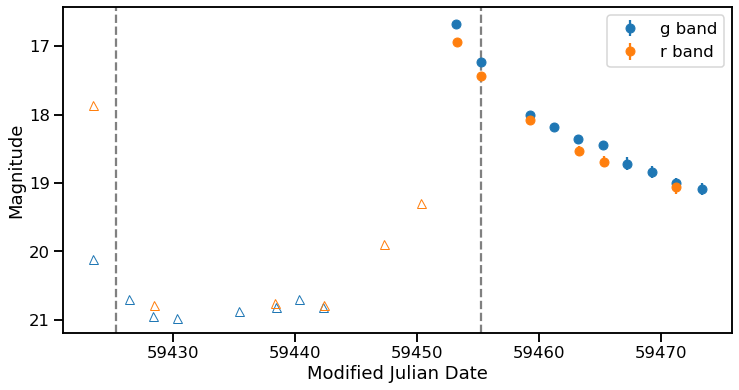

https://fink-portal.org/ZTF21abvrrir


In [6]:
oid = pdf_kn_lc_model2['objectId'].values[0]
kn_trigger = pdf_kn_lc_model2['candidate'].apply(lambda x: x['jd']).values[0]

r = requests.post(
  '{}/api/v1/objects'.format(APIURL),
  json={
    'objectId': oid,
    'withupperlim': 'True'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

fig = plt.figure(figsize=(12, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}
for filt in np.unique(pdf['i:fid']):
    maskFilt = pdf['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf['d:tag'] == 'valid'
    plt.errorbar(
        pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf[maskValid & maskFilt]['i:magpsf'],
        pdf[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    maskUpper = pdf['d:tag'] == 'upperlim'
    plt.plot(
        pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='^', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf['d:tag'] == 'badquality'
    plt.errorbar(
        pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf[maskBadquality & maskFilt]['i:magpsf'],
        pdf[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='v', mew=2, color=colordic[filt]
    )

plt.axvline(kn_trigger - 2400000.5, ls='--', color='grey')
plt.axvline(kn_trigger - 2400000.5 - 30, ls='--', color='grey')
plt.gca().invert_yaxis()
plt.xlabel('Modified Julian Date')
plt.ylabel('Magnitude')
plt.legend()
# plt.title('{}'.format(oid))
plt.show()
print('{}/{}'.format(APIURL, oid))

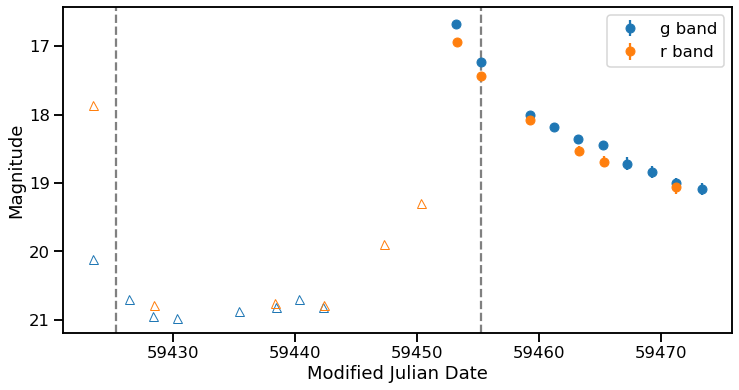

https://fink-portal.org/ZTF21abvrrir


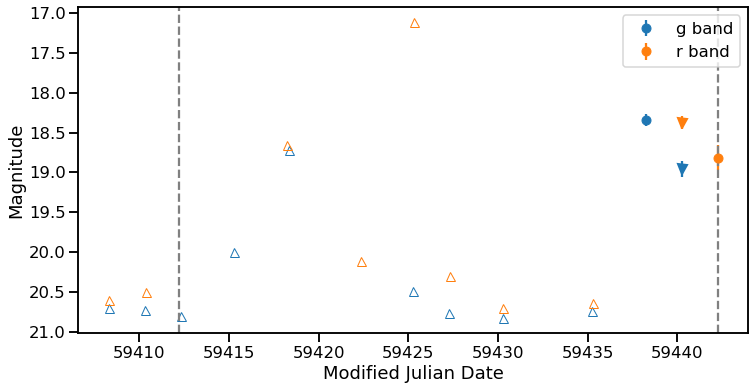

https://fink-portal.org/ZTF21absmlzd


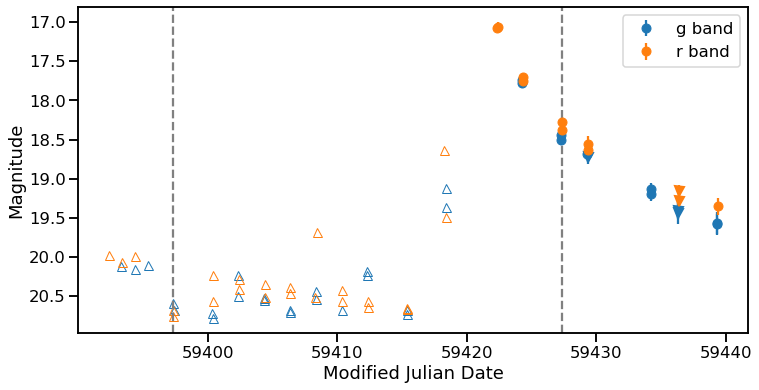

https://fink-portal.org/ZTF21aboulpc


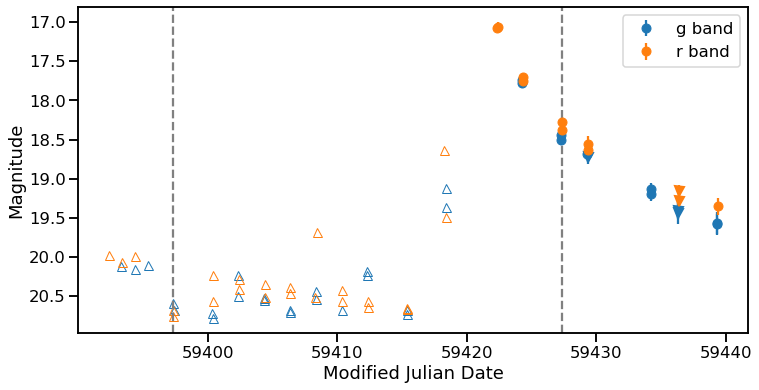

https://fink-portal.org/ZTF21aboulpc


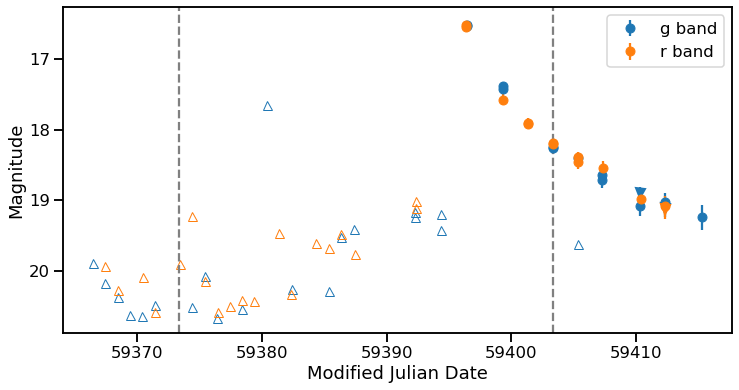

https://fink-portal.org/ZTF21abitmou


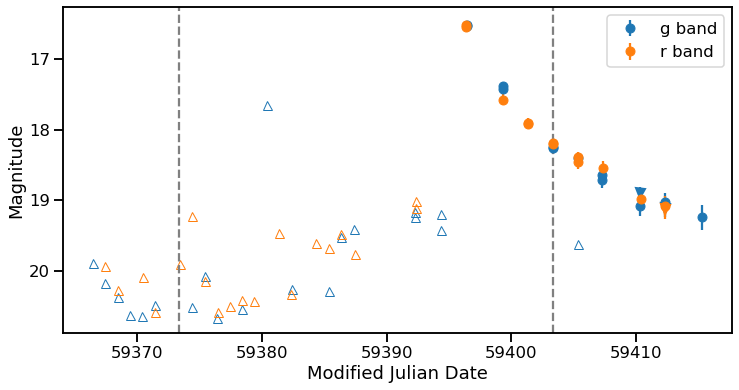

https://fink-portal.org/ZTF21abitmou


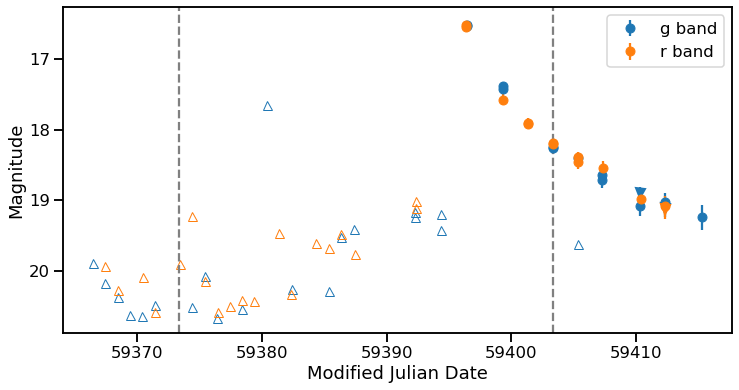

https://fink-portal.org/ZTF21abitmou


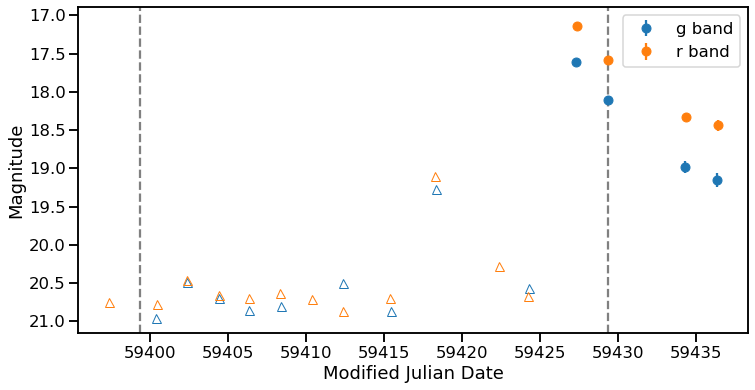

https://fink-portal.org/ZTF21abqfzcp


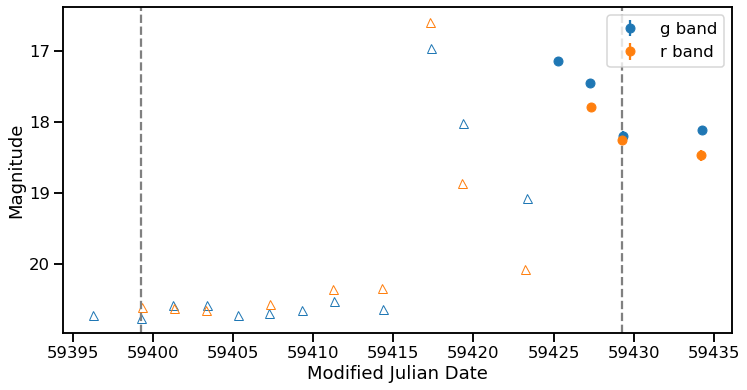

https://fink-portal.org/ZTF21abppezh


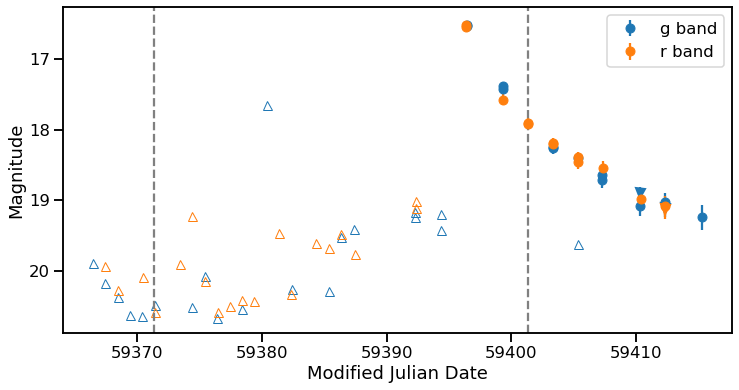

https://fink-portal.org/ZTF21abitmou


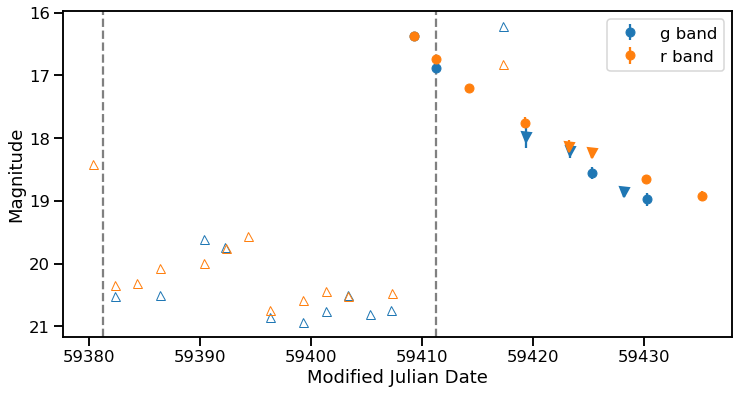

https://fink-portal.org/ZTF21ablssud


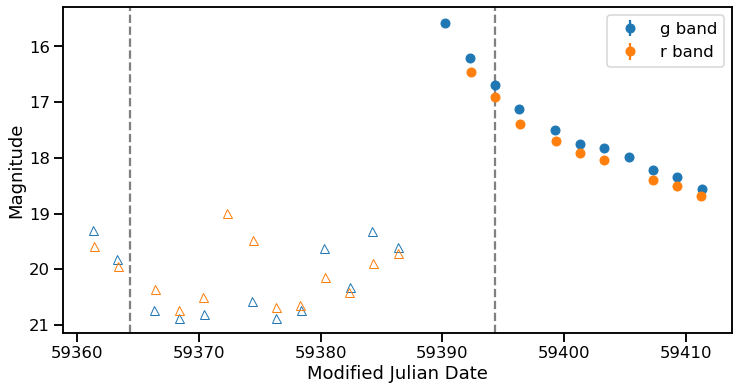

https://fink-portal.org/ZTF21abhytgb


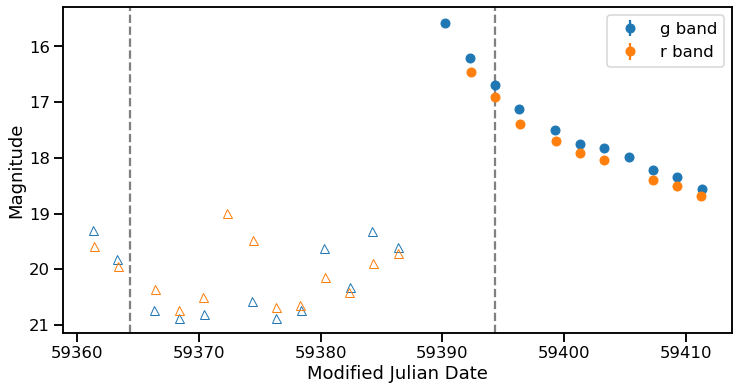

https://fink-portal.org/ZTF21abhytgb


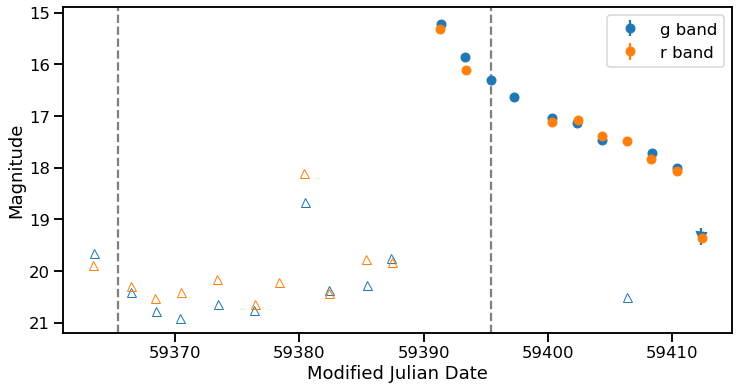

https://fink-portal.org/ZTF21abiblog


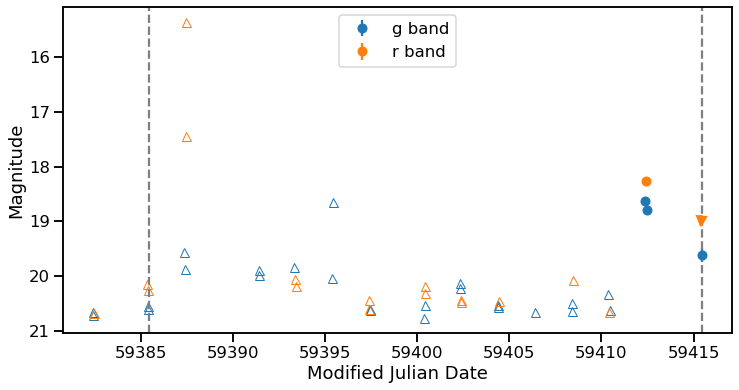

https://fink-portal.org/ZTF21abmoupj


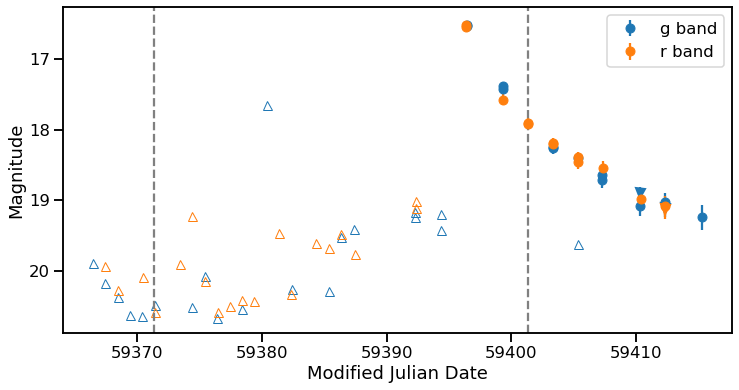

https://fink-portal.org/ZTF21abitmou


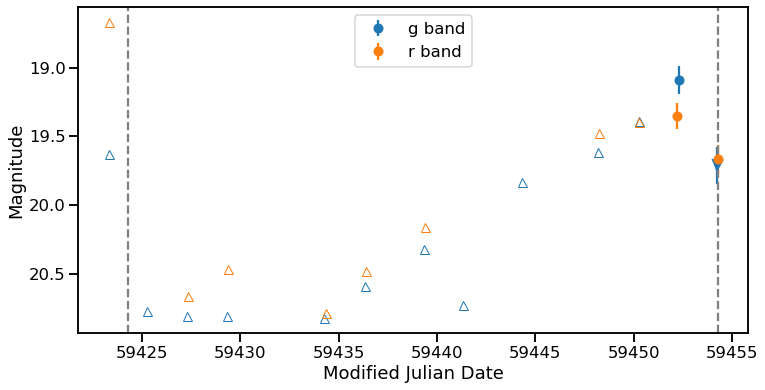

https://fink-portal.org/ZTF21abvevwh


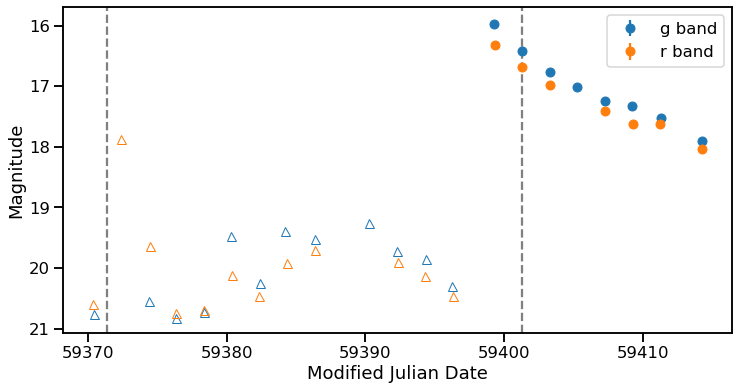

https://fink-portal.org/ZTF21abjdjhk


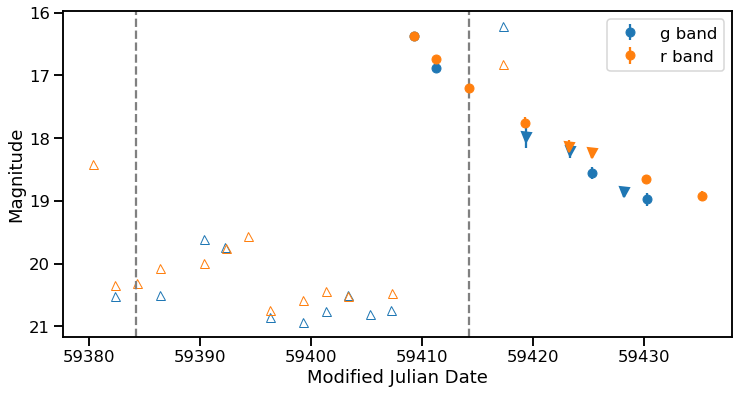

https://fink-portal.org/ZTF21ablssud


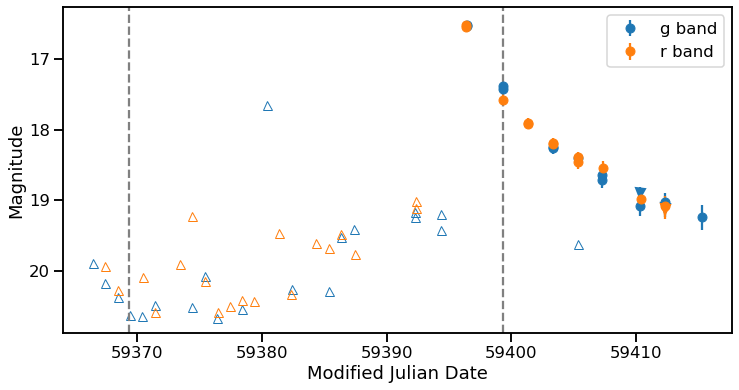

https://fink-portal.org/ZTF21abitmou


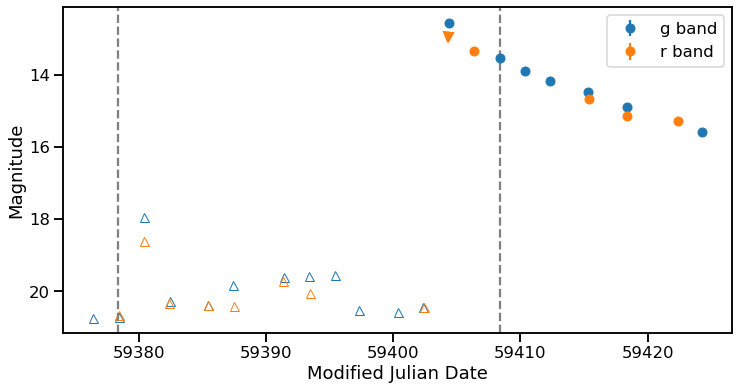

https://fink-portal.org/ZTF21abkjvko


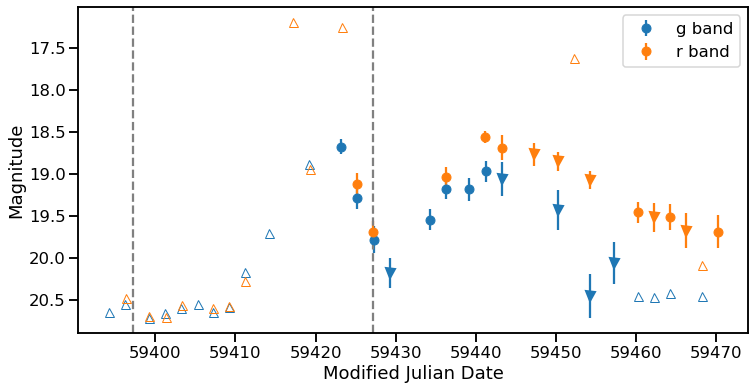

https://fink-portal.org/ZTF21abotose


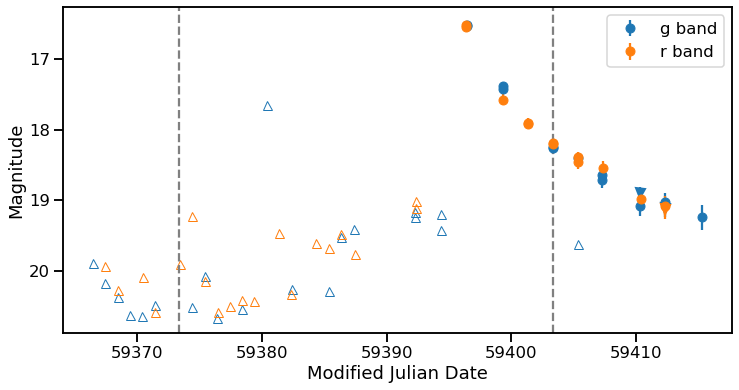

https://fink-portal.org/ZTF21abitmou


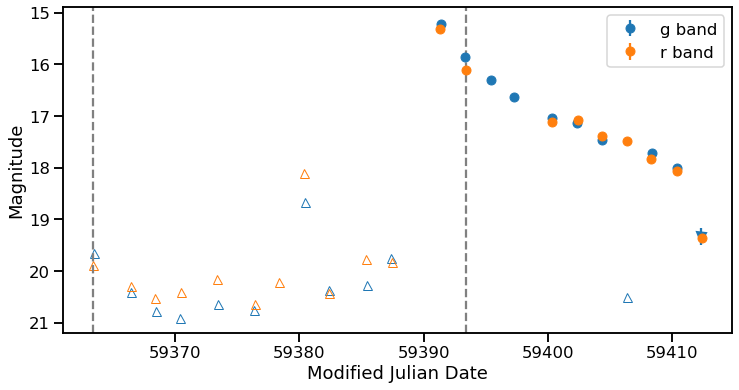

https://fink-portal.org/ZTF21abiblog


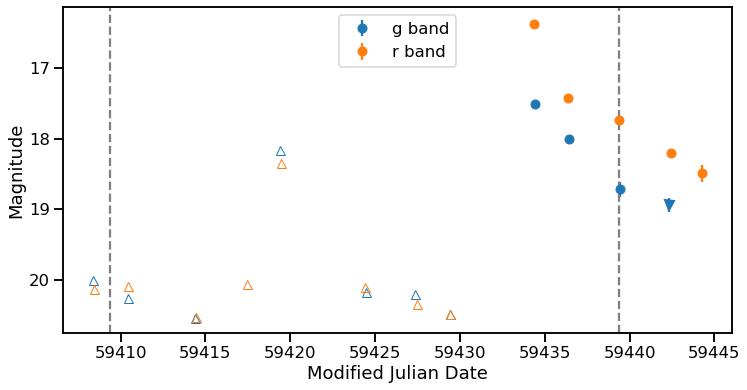

https://fink-portal.org/ZTF21abrlwud


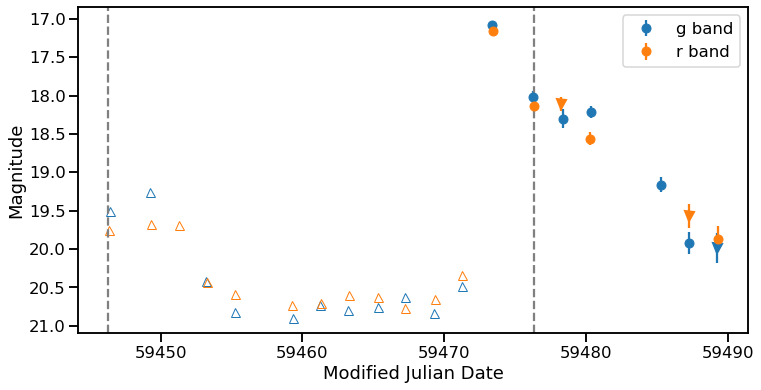

https://fink-portal.org/ZTF21accbxzk


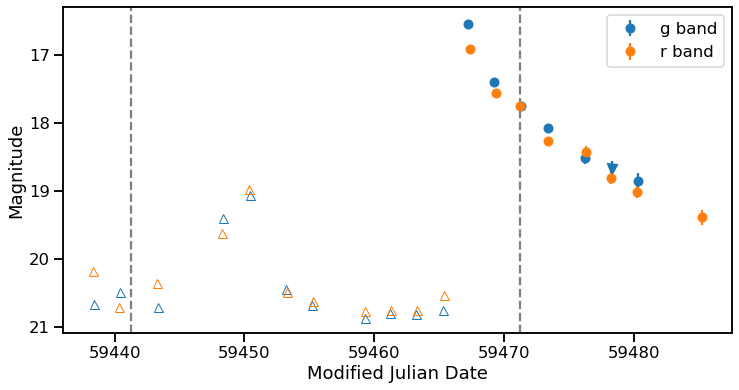

https://fink-portal.org/ZTF21acahxze


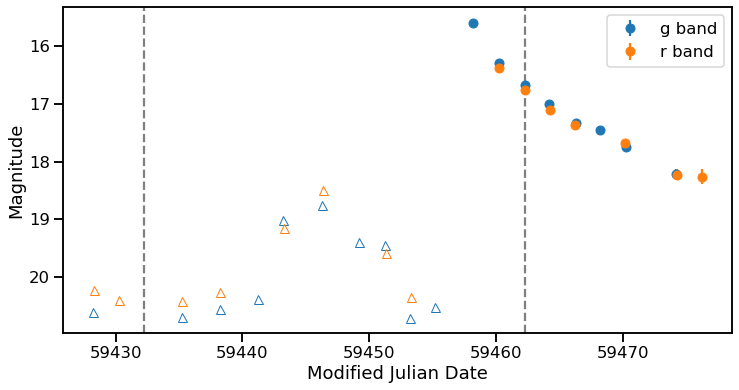

https://fink-portal.org/ZTF21abwplpy


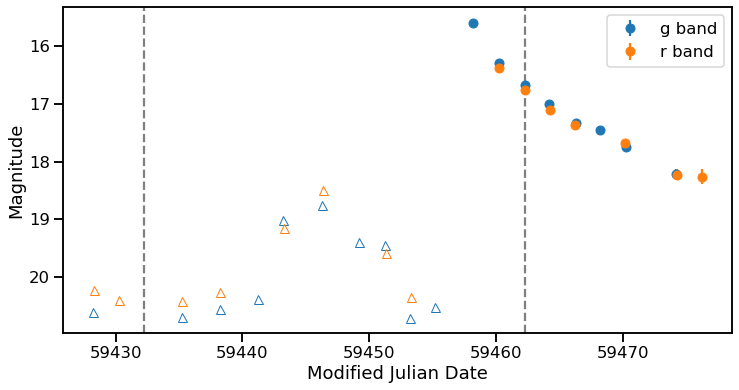

https://fink-portal.org/ZTF21abwplpy


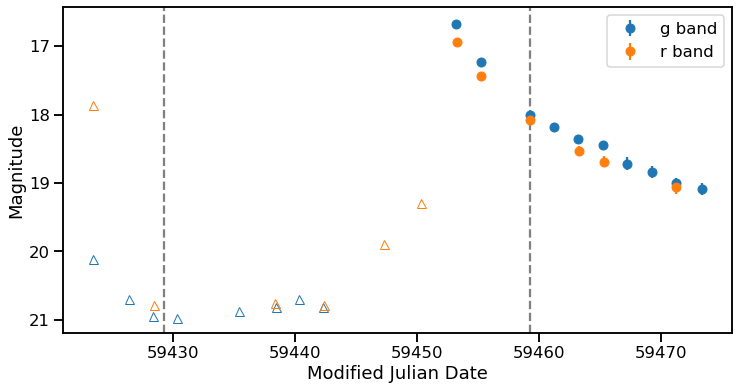

https://fink-portal.org/ZTF21abvrrir


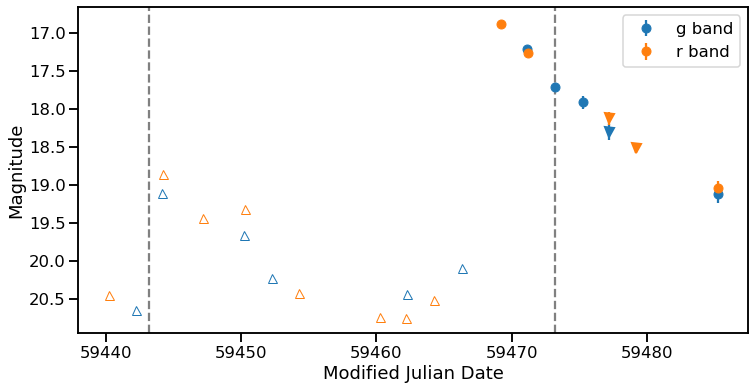

https://fink-portal.org/ZTF21acbfpwj


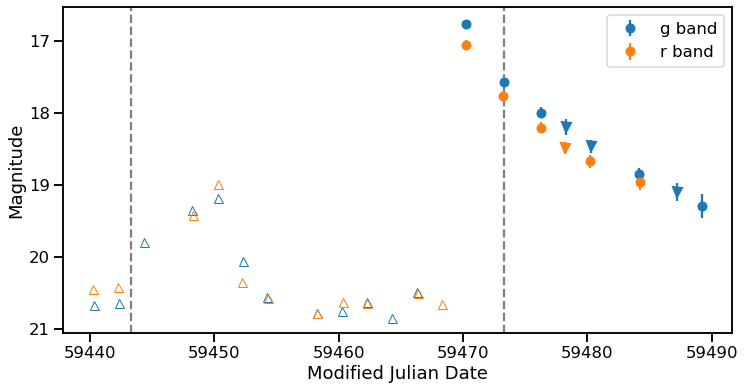

https://fink-portal.org/ZTF21acbqmnb


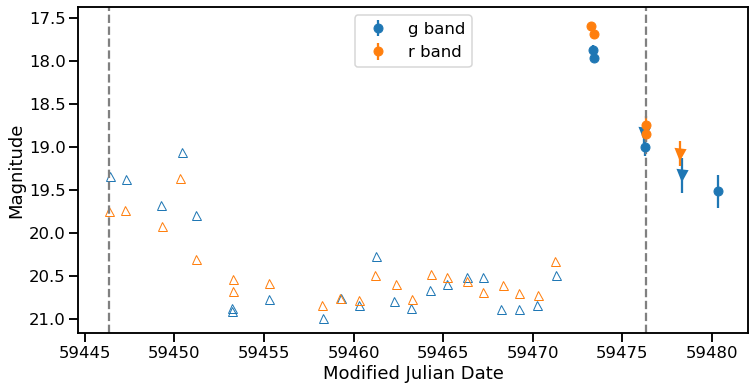

https://fink-portal.org/ZTF21accmlne


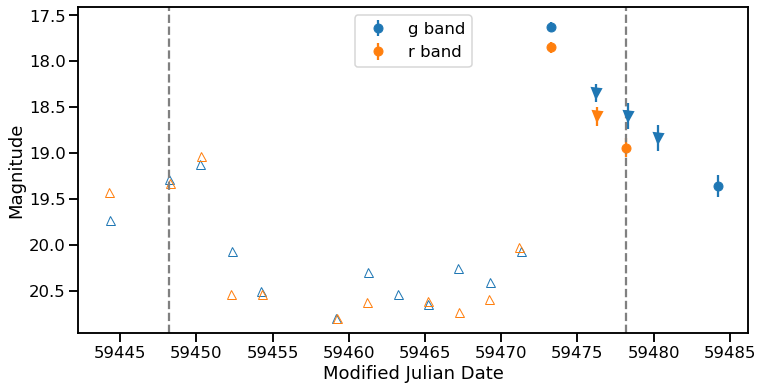

https://fink-portal.org/ZTF21accmmxm


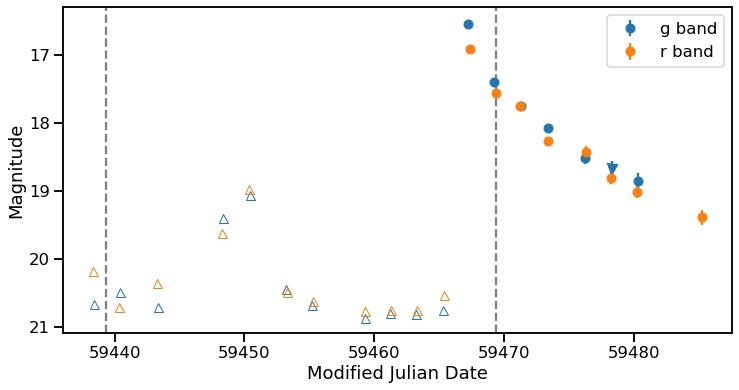

https://fink-portal.org/ZTF21acahxze


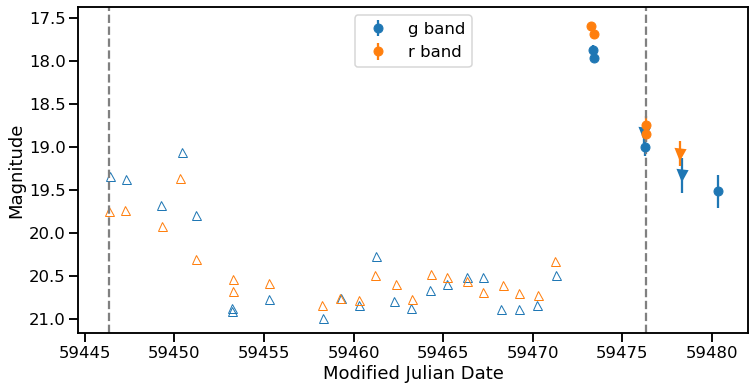

https://fink-portal.org/ZTF21accmlne


In [7]:
oids = pdf_kn_lc_model2['objectId'].values
kn_triggers = pdf_kn_lc_model2['candidate'].apply(lambda x: x['jd']).values

for oid, kn_trigger in zip(oids, kn_triggers):
    r = requests.post(
      '{}/api/v1/objects'.format(APIURL),
      json={
        'objectId': oid,
        'withupperlim': 'True'
      }
    )

    # Format output in a DataFrame
    pdf = pd.read_json(r.content)

    fig = plt.figure(figsize=(12, 6))

    colordic = {1: 'C0', 2: 'C1'}
    filtdic = {1: 'g', 2: 'r'}
    for filt in np.unique(pdf['i:fid']):
        maskFilt = pdf['i:fid'] == filt

        # The column `d:tag` is used to check data type
        maskValid = pdf['d:tag'] == 'valid'
        plt.errorbar(
            pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskValid & maskFilt]['i:magpsf'],
            pdf[maskValid & maskFilt]['i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
        )

        maskUpper = pdf['d:tag'] == 'upperlim'
        plt.plot(
            pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskUpper & maskFilt]['i:diffmaglim'],
            ls='', marker='^', color=colordic[filt], markerfacecolor='none'
        )

        maskBadquality = pdf['d:tag'] == 'badquality'
        plt.errorbar(
            pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskBadquality & maskFilt]['i:magpsf'],
            pdf[maskBadquality & maskFilt]['i:sigmapsf'],
            ls='', marker='v', mew=2, color=colordic[filt]
        )

    plt.axvline(kn_trigger - 2400000.5, ls='--', color='grey')
    plt.axvline(kn_trigger - 2400000.5 - 30, ls='--', color='grey')
    plt.gca().invert_yaxis()
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')
    plt.legend()
    # plt.title('{}'.format(oid))
    plt.show()
    print('{}/{}'.format(APIURL, oid))

Circles (●) with error bars show valid alerts that pass the Fink quality cuts. Upper triangles with errors (▲), representing alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers. Lower triangles (▽), representing 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts. The vertical line shows the KN trigger by Fink.

## Evolution of the classification

Each alert was triggered because the Fink pipelines favoured the KN flavor at the time of emission. But the underlying object on the sky might have generated further alerts after, and the classification could evolve. For a handful of alerts, let see what they became. For this, we will use the Fink REST API, and query all the data for the underlying object:

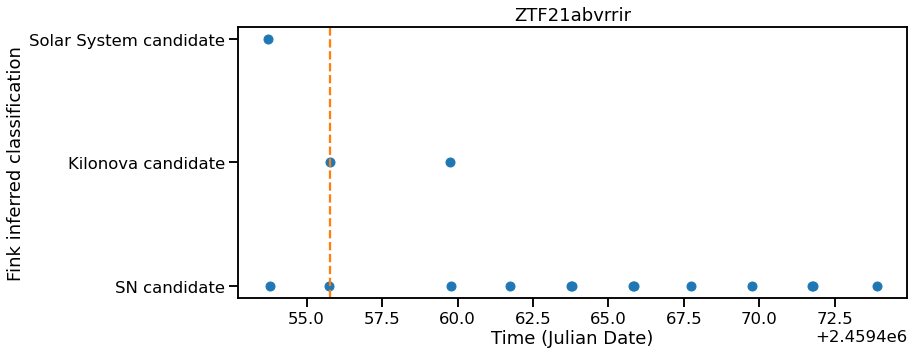

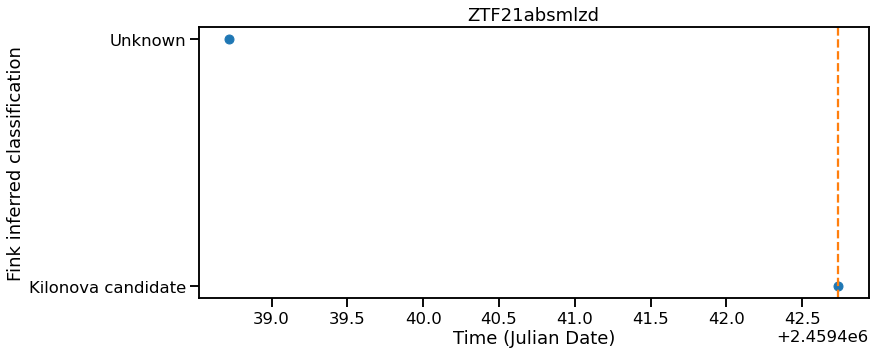

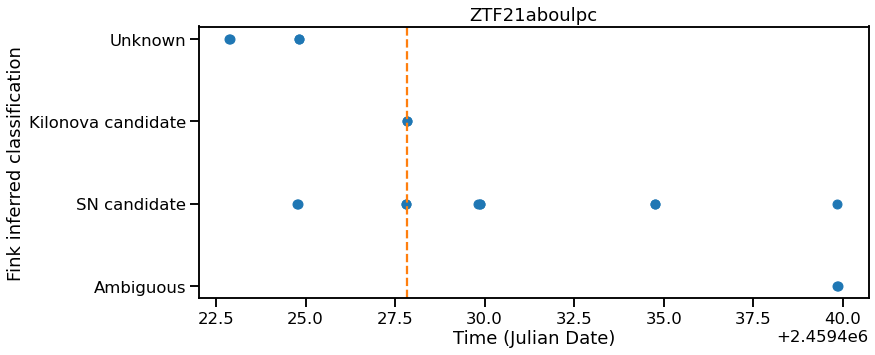

In [8]:
NALERTS = 3
oids = pdf_kn_lc_model2['objectId'].values[0: NALERTS]
kn_triggers = pdf_kn_lc_model2['candidate'].apply(lambda x: x['jd']).values[0: NALERTS]

for oid, kn_trigger in zip(oids, kn_triggers):
    r = requests.post(
      '{}/api/v1/objects'.format(APIURL),
      json={
        'objectId': oid,
        'output-format': 'json'
      }
    )

    # Format output in a DataFrame
    pdf_ = pd.read_json(r.content)
    times, classes = np.transpose(pdf_[['i:jd','v:classification']].values)
    
    fig = plt.figure(figsize=(12, 5))
    
    plt.plot(times, classes, ls='', marker='o')
    plt.axvline(kn_trigger, ls='--', color='C1')
    
    plt.title(oid)
    plt.xlabel('Time (Julian Date)')
    plt.ylabel('Fink inferred classification')
    plt.show()

One can see that alert classification for a given object can change over time. With time, we collect more data, and have a clearer view on the nature of the object. Let's make an histogram of the final classification for each object (~1min to run)

In [9]:
final_classes_model1 = []
oids = np.unique(pdf_kn_lc_model1['objectId'].values)
for oid in oids:
    r = requests.post(
      '{}/api/v1/objects'.format(APIURL),
      json={
        'objectId': oid,
        'output-format': 'json'
      }
    )
    pdf_ = pd.read_json(r.content)
    final_classes_model1.append(pdf_['v:classification'].values[0])
    
final_classes_model2 = []
oids = np.unique(pdf_kn_lc_model2['objectId'].values)
for oid in oids:
    r = requests.post(
      '{}/api/v1/objects'.format(APIURL),
      json={
        'objectId': oid,
        'output-format': 'json'
      }
    )
    pdf_ = pd.read_json(r.content)
    final_classes_model2.append(pdf_['v:classification'].values[0])

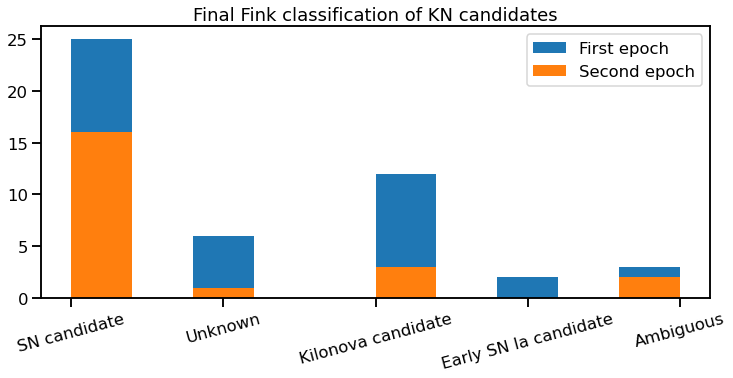

In [10]:
fig = plt.figure(figsize=(12, 5))

plt.hist(final_classes_model1, label='First epoch')
plt.hist(final_classes_model2, label='Second epoch')

plt.xticks(rotation=15.)
plt.title('Final Fink classification of KN candidates')
plt.legend();

Most of the objects are now SN candidates according to Fink.

## Follow-up of candidates by other instruments

Some of the alerts benefited from follow-up by other instruments to determine their nature. Usually this information can be found on the TNS server (although this is highly biased towards Supernovae). We attached this information to the alerts (if it exists):

In [11]:
pdf_kn_lc.groupby('TNS').count().sort_values('objectId', ascending=False)['objectId']

TNS
                     52
SN Ia                36
CV                    8
SN Iax[02cx-like]     3
SN II                 2
SN Ia-pec             2
SN Ic-BL              2
SN IIb                1
SN Ib                 1
Name: objectId, dtype: int64

We can see that among the total 96 ZTF alerts forwarded by Fink, 45 have no known counterpart in TNS (i.e. no follow-up result was reported). More surprising, we have 36 alerts that were confirmed as Supernova type Ia! Usually SN Ia and KN models are quite different, so why this confusion?

This is partially why we updated the model during the campaign. If we split the classification per epoch, one can see that the second epoch led to more meaningful results:

In [12]:
pdf_kn_lc_model1.groupby('TNS').count().sort_values('objectId', ascending=False)['objectId']

TNS
SN Ia                36
                     23
SN Iax[02cx-like]     3
CV                    2
SN II                 2
SN Ia-pec             2
SN Ic-BL              2
SN Ib                 1
Name: objectId, dtype: int64

In [13]:
pdf_kn_lc_model2.groupby('TNS').count().sort_values('objectId', ascending=False)['objectId']

TNS
          29
CV         6
SN IIb     1
Name: objectId, dtype: int64

Ah, this is better! No more SN Ia. Most of the alerts after the change have no known classification in TNS, and we have a small contaminant from 2 cataclysmic variables and one SN  IIb.

## Classification delay

Let's see the time delay between the first detection of the object variability by ZTF and the Fink trigger:

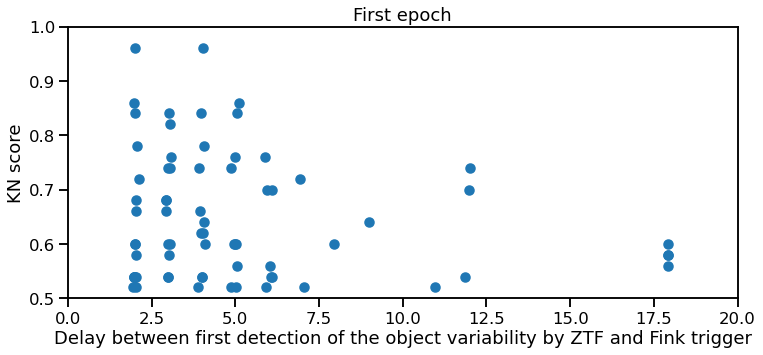

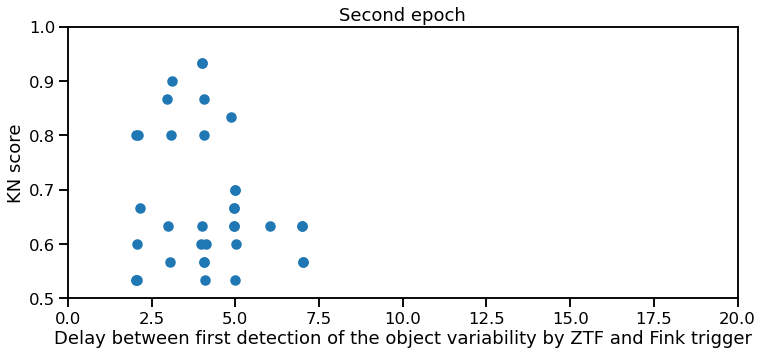

In [14]:
for pdf_ in [pdf_kn_lc_model1, pdf_kn_lc_model2]:
    fig = plt.figure(figsize=(12, 5))

    jd_trigger = pdf_['candidate'].apply(lambda x: x['jd'])
    jd0 = pdf_['candidate'].apply(lambda x: x['jdstarthist'])
    knscore = pdf_['knscore']
    
    plt.scatter(jd_trigger - jd0, knscore)
    
    plt.xlim(0, 20)
    plt.ylim(0.5, 1.0)
    plt.xlabel('Delay between first detection of the object variability by ZTF and Fink trigger')
    plt.ylabel('KN score')
    
    if pdf_['fink_science_version'].values[0] > '0.4.4':
        plt.title('Second epoch')
    else:
        plt.title('First epoch')
    plt.show()

During the first epoch, we could classify objects as soon as 2 days after their first detection by ZTF, but we had outliers with long time delay. During the 2nd epoch, classification is between 2 and 7 days.

## Rates

Let's compute the last rate in the history of candidate alerts (for the same filter):

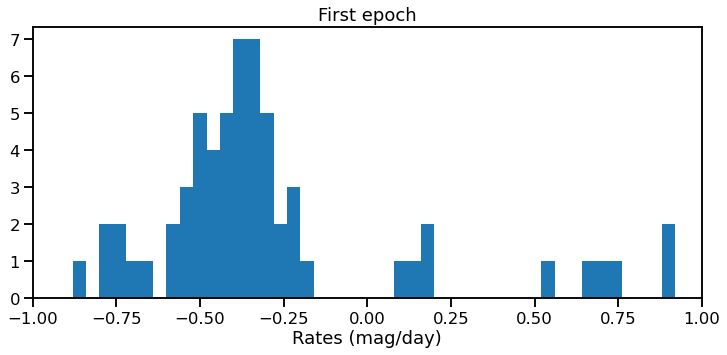

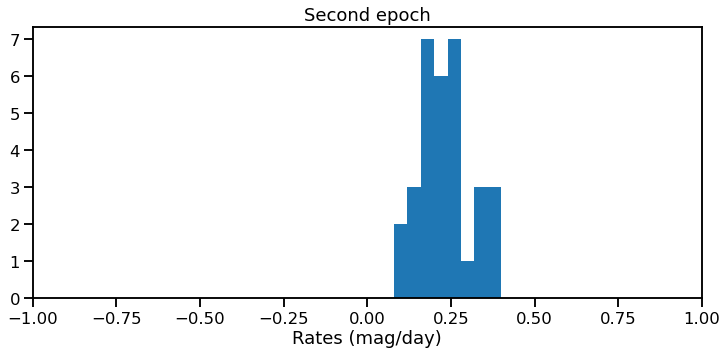

In [15]:
for pdf_ in [pdf_kn_lc_model1, pdf_kn_lc_model2]:
    fig = plt.figure(figsize=(12, 5))

    mags = pdf_['cmagpsfc']
    filts = pdf_['cfidc']
    jds = pdf_['cjdc']
    
    rates = []
    for mag, filt, jd in zip(mags, filts, jds):
        last_filt = filt[-1]
        mask = np.where(filt == last_filt)[0]
        diff_mag = mag[mask][-1] - mag[mask][-2]
        diff_jd = jd[mask][-1] - jd[mask][-2]
        rate = diff_mag / diff_jd
        if np.abs(rate) > 2:
            rates.append(np.nan)
        else:
            rates.append(rate)
    
    
    plt.hist(rates, bins=50, range=[-1, 1])
    
    plt.xlim(-1, 1)
    plt.xlabel('Rates (mag/day)')
    
    if pdf_['fink_science_version'].values[0] > '0.4.4':
        plt.title('Second epoch')
    else:
        plt.title('First epoch')
    plt.show()

With the 1PC classifier, the rates have small, negative values that don’t match the expected values for a kilonova. With the 2PC classifier, the value of the rates are better, averaging at 0.24 mag/day when a good threshold for the rate would be typically 0.3.

Note, we computed a "naive" rate, using difference magnitude and only the last 2 measurements in a band. Let's see a more robust computation using apparent magnitude, and all measurements in a band:

/Users/julien/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


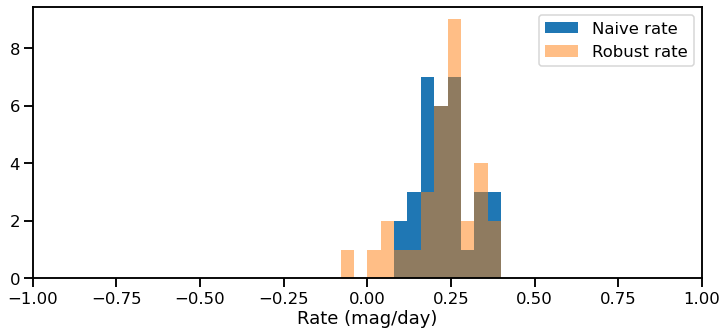

In [16]:
fig = plt.figure(figsize=(12, 5))

mags = pdf_kn_lc_model2['cmagpsfc']
errs = pdf_kn_lc_model2['csigmapsfc']
filts = pdf_kn_lc_model2['cfidc']
jds = pdf_kn_lc_model2['cjdc']
magnrs = pdf_kn_lc_model2['cmagnrc']
sigmanrs = pdf_kn_lc_model2['csigmagnrc']
magzpscis = pdf_kn_lc_model2['cmagzpscic']
isdiffposs = pdf_kn_lc_model2['cisdiffposc']

rates = []
rates2 = []
for mag, err, filt, jd, magnr, sigmanr, magzpsci, isdiffpos in zip(mags, errs, filts, jds, magnrs, sigmanrs, magzpscis, isdiffposs):
    maskNotNone = mag == mag

    last_filt = filt[-1]
    mask = filt == last_filt
    
    # Compute naive rate (difference between last two measurements in a band)
    diff_mag = mag[mask][-1] - mag[mask][-2]
    diff_jd = jd[mask][-1] - jd[mask][-2]
    rate = diff_mag / diff_jd
    
    # Compute proper rate using DC mag, and all the measurements in a band
    # Diff mag to DC mag (history + last measurement)
    mag_, err_ = np.array([
        dc_mag(k[0], k[1], k[2], k[3], k[4], k[5], k[6])
        for k in zip(
            filt,
            mag,
            err,
            magnr,
            sigmanr,
            magzpsci,
            isdiffpos,
        )
    ]).T
    
    popt, pcov = curve_fit(
        lambda x, a, b: a*x + b,
        jd[mask*maskNotNone],
        mag_[mask*maskNotNone],
        sigma=err_[mask*maskNotNone],
    )
    
    rate2 = popt[0]
    
    if np.abs(rate) > 2:
        rates.append(np.nan)
        rates2.append(np.nan)
    else:
        rates.append(rate)
        rates2.append(rate2)


plt.hist(rates, bins=50, range=[-1, 1], label='Naive rate')
plt.hist(rates2, bins=50, range=[-1, 1], label='Robust rate', alpha=0.5)

plt.xlim(-1, 1)
plt.xlabel('Rate (mag/day)')
plt.legend()

plt.show()

We can see that new rates are centered around 0.25, with a long tail towards negative values. We could filter these events (see the rate-based filter notebook).